# Method 2 - Rest Ideas After 1

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 1].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

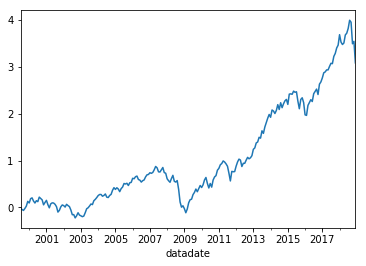

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.128154
2000-12-31   -0.021335
2001-12-31   -0.048213
2002-12-31   -0.206224
2003-12-31    0.448413
2004-12-31    0.175830
2005-12-31    0.079402
2006-12-31    0.110276
2007-12-31    0.015612
2008-12-31   -0.402440
2009-12-31    0.419928
2010-12-31    0.222869
2011-12-31   -0.016666
2012-12-31    0.192627
2013-12-31    0.418361
2014-12-31    0.107878
2015-12-31   -0.020870
2016-12-31    0.136546
2017-12-31    0.213655
2018-12-31   -0.084887
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2941.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.63e-195
Time:                        03:00:20   Log-Likelihood:                 841.63
No. Observations:                 234   AIC:                            -1673.
Df Residuals:                     229   BIC:                            -1656.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      4.532      0.000       0.001       0.003
mktrf          1.0088      0.013     80.665      0.000       0.984       1.033
me             0.2760      0.015     18.975      0.000       0.247       0.305
ia             0.0576      0.022      2.603      0.010       0.014       0.101
roe           -0.0259      0.019     -1.369      0.172      -0.063       0.011
==============================================================================
Omnibus:                       26.622   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.334
Skew:                          -0.139   Prob(JB):                     4.99e-29
Kurtosis:                       6.646   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     1755.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.73e-170
Time:                        03:00:20   Log-Likelihood:                 841.63
No. Observations:                 234   AIC:                            -1673.
Df Residuals:                     229   BIC:                            -1656.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      4.610      0.000       0.001       0.003
mktrf          1.0088      0.016     62.798      0.000       0.977       1.040
me             0.2760      0.024     11.693      0.000       0.230       0.322
ia             0.0576      0.045      1.276      0.202      -0.031       0.146
roe           -0.0259      0.025     -1.018      0.309      -0.076       0.024
==============================================================================
Omnibus:                       26.622   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.334
Skew:                          -0.139   Prob(JB):                     4.99e-29
Kurtosis:                       6.646   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2188.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.88e-181
Time:                        03:00:20   Log-Likelihood:                 841.63
No. Observations:                 234   AIC:                            -1673.
Df Residuals:                     229   BIC:                            -1656.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.000      5.017      0.000       0.001       0.003
mktrf          1.0088      0.016     64.901      0.000       0.978       1.039
me             0.2760      0.022     12.338      0.000       0.232       0.320
ia             0.0576      0.048      1.206      0.228      -0.036       0.151
roe           -0.0259      0.028     -0.914      0.361      -0.081       0.030
==============================================================================
Omnibus:                       26.622   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.334
Skew:                          -0.139   Prob(JB):                     4.99e-29
Kurtosis:                       6.646   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1970.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.32e-185
Time:                        03:00:20   Log-Likelihood:                 821.79
No. Observations:                 234   AIC:                            -1632.
Df Residuals:                     228   BIC:                            -1611.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.614      0.000       0.001       0.003
mktrf          1.0209      0.014     74.686      0.000       0.994       1.048
smb            0.3021      0.018     16.748      0.000       0.267       0.338
hml            0.0202      0.021      0.948      0.344      -0.022       0.062
rmw           -0.0056      0.024     -0.232      0.817      -0.053       0.042
cma            0.0477      0.031      1.559      0.120      -0.013       0.108
==============================================================================
Omnibus:                       27.435   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.196
Skew:                           0.038   Prob(JB):                     6.60e-33
Kurtosis:                       6.898   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1464.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.67e-171
Time:                        03:00:20   Log-Likelihood:                 821.79
No. Observations:                 234   AIC:                            -1632.
Df Residuals:                     228   BIC:                            -1611.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.449      0.001       0.001       0.003
mktrf          1.0209      0.018     57.281      0.000       0.986       1.056
smb            0.3021      0.023     12.989      0.000       0.256       0.348
hml            0.0202      0.049      0.413      0.679      -0.075       0.116
rmw           -0.0056      0.028     -0.202      0.840      -0.060       0.049
cma            0.0477      0.051      0.941      0.347      -0.052       0.147
==============================================================================
Omnibus:                       27.435   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.196
Skew:                           0.038   Prob(JB):                     6.60e-33
Kurtosis:                       6.898   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     2063.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.41e-187
Time:                        03:00:20   Log-Likelihood:                 821.79
No. Observations:                 234   AIC:                            -1632.
Df Residuals:                     228   BIC:                            -1611.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      3.463      0.001       0.001       0.003
mktrf          1.0209      0.017     59.685      0.000       0.987       1.054
smb            0.3021      0.024     12.846      0.000       0.256       0.348
hml            0.0202      0.052      0.388      0.698      -0.082       0.122
rmw           -0.0056      0.030     -0.186      0.852      -0.064       0.053
cma            0.0477      0.050      0.954      0.340      -0.050       0.146
==============================================================================
Omnibus:                       27.435   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.196
Skew:                           0.038   Prob(JB):                     6.60e-33
Kurtosis:                       6.898   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2211.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.22e-181
Time:                        03:00:20   Log-Likelihood:                 808.98
No. Observations:                 234   AIC:                            -1608.
Df Residuals:                     229   BIC:                            -1591.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.912      0.000       0.001       0.003
mktrf          1.0154      0.013     76.703      0.000       0.989       1.041
smb            0.2882      0.017     17.439      0.000       0.256       0.321
hml            0.0941      0.016      5.730      0.000       0.062       0.126
umd           -0.0066      0.011     -0.610      0.542      -0.028       0.015
==============================================================================
Omnibus:                       28.867   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.978
Skew:                           0.074   Prob(JB):                     1.50e-36
Kurtosis:                       7.111   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1823.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.59e-172
Time:                        03:00:20   Log-Likelihood:                 808.98
No. Observations:                 234   AIC:                            -1608.
Df Residuals:                     229   BIC:                            -1591.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.262      0.001       0.001       0.003
mktrf          1.0154      0.019     54.456      0.000       0.979       1.052
smb            0.2882      0.024     12.055      0.000       0.241       0.335
hml            0.0941      0.049      1.912      0.056      -0.002       0.190
umd           -0.0066      0.020     -0.331      0.740      -0.045       0.032
==============================================================================
Omnibus:                       28.867   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.978
Skew:                           0.074   Prob(JB):                     1.50e-36
Kurtosis:                       7.111   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     2461.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.88e-187
Time:                        03:00:20   Log-Likelihood:                 808.98
No. Observations:                 234   AIC:                            -1608.
Df Residuals:                     229   BIC:                            -1591.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.252      0.001       0.001       0.003
mktrf          1.0154      0.016     63.303      0.000       0.984       1.047
smb            0.2882      0.025     11.480      0.000       0.239       0.337
hml            0.0941      0.055      1.711      0.087      -0.014       0.202
umd           -0.0066      0.016     -0.414      0.679      -0.038       0.025
==============================================================================
Omnibus:                       28.867   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.978
Skew:                           0.074   Prob(JB):                     1.50e-36
Kurtosis:                       7.111   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1316.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.32e-95
Time:                        03:00:20   Log-Likelihood:                 413.15
No. Observations:                 120   AIC:                            -816.3
Df Residuals:                     115   BIC:                            -802.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.427      0.001       0.001       0.004
mktrf          1.0156      0.020     49.861      0.000       0.975       1.056
me             0.2582      0.020     12.836      0.000       0.218       0.298
ia             0.0950      0.032      3.016      0.003       0.033       0.157
roe           -0.0204      0.028     -0.732      0.466      -0.076       0.035
==============================================================================
Omnibus:                       11.007   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               28.739
Skew:                          -0.086   Prob(JB):                     5.75e-07
Kurtosis:                       5.391   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1048.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.94e-89
Time:                        03:00:20   Log-Likelihood:                 413.15
No. Observations:                 120   AIC:                            -816.3
Df Residuals:                     115   BIC:                            -802.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.461      0.001       0.001       0.004
mktrf          1.0156      0.027     37.528      0.000       0.963       1.069
me             0.2582      0.024     10.739      0.000       0.211       0.305
ia             0.0950      0.049      1.950      0.051      -0.000       0.191
roe           -0.0204      0.031     -0.661      0.509      -0.081       0.040
==============================================================================
Omnibus:                       11.007   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               28.739
Skew:                          -0.086   Prob(JB):                     5.75e-07
Kurtosis:                       5.391   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1635.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.60e-100
Time:                        03:00:20   Log-Likelihood:                 413.15
No. Observations:                 120   AIC:                            -816.3
Df Residuals:                     115   BIC:                            -802.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.609      0.000       0.001       0.004
mktrf          1.0156      0.024     43.111      0.000       0.969       1.062
me             0.2582      0.023     11.099      0.000       0.213       0.304
ia             0.0950      0.045      2.101      0.036       0.006       0.184
roe           -0.0204      0.032     -0.640      0.522      -0.083       0.042
==============================================================================
Omnibus:                       11.007   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               28.739
Skew:                          -0.086   Prob(JB):                     5.75e-07
Kurtosis:                       5.391   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     839.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.84e-88
Time:                        03:00:20   Log-Likelihood:                 400.37
No. Observations:                 120   AIC:                            -788.7
Df Residuals:                     114   BIC:                            -772.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.262      0.001       0.001       0.005
mktrf          1.0558      0.024     43.998      0.000       1.008       1.103
smb            0.3000      0.027     11.036      0.000       0.246       0.354
hml           -0.0040      0.033     -0.121      0.904      -0.070       0.062
rmw            0.0293      0.039      0.745      0.458      -0.049       0.107
cma            0.1114      0.043      2.589      0.011       0.026       0.197
==============================================================================
Omnibus:                       12.561   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               37.473
Skew:                          -0.092   Prob(JB):                     7.29e-09
Kurtosis:                       5.731   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     895.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.07e-89
Time:                        03:00:20   Log-Likelihood:                 400.37
No. Observations:                 120   AIC:                            -788.7
Df Residuals:                     114   BIC:                            -772.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.217      0.001       0.001       0.005
mktrf          1.0558      0.034     30.734      0.000       0.989       1.123
smb            0.3000      0.036      8.429      0.000       0.230       0.370
hml           -0.0040      0.079     -0.051      0.960      -0.160       0.152
rmw            0.0293      0.060      0.490      0.624      -0.088       0.146
cma            0.1114      0.063      1.769      0.077      -0.012       0.235
==============================================================================
Omnibus:                       12.561   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               37.473
Skew:                          -0.092   Prob(JB):                     7.29e-09
Kurtosis:                       5.731   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1593.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.11e-103
Time:                        03:00:20   Log-Likelihood:                 400.37
No. Observations:                 120   AIC:                            -788.7
Df Residuals:                     114   BIC:                            -772.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.401      0.001       0.001       0.004
mktrf          1.0558      0.033     32.134      0.000       0.991       1.120
smb            0.3000      0.037      8.205      0.000       0.228       0.372
hml           -0.0040      0.086     -0.047      0.963      -0.172       0.164
rmw            0.0293      0.065      0.448      0.654      -0.099       0.157
cma            0.1114      0.063      1.780      0.075      -0.011       0.234
==============================================================================
Omnibus:                       12.561   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               37.473
Skew:                          -0.092   Prob(JB):                     7.29e-09
Kurtosis:                       5.731   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     909.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.16e-86
Time:                        03:00:20   Log-Likelihood:                 391.55
No. Observations:                 120   AIC:                            -773.1
Df Residuals:                     115   BIC:                            -759.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.769      0.000       0.002       0.005
mktrf          1.0265      0.021     47.779      0.000       0.984       1.069
smb            0.2783      0.024     11.376      0.000       0.230       0.327
hml            0.1148      0.024      4.687      0.000       0.066       0.163
umd           -0.0039      0.015     -0.255      0.799      -0.034       0.026
==============================================================================
Omnibus:                       13.636   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               45.540
Skew:                          -0.036   Prob(JB):                     1.29e-10
Kurtosis:                       6.017   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1274.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.30e-94
Time:                        03:00:20   Log-Likelihood:                 391.55
No. Observations:                 120   AIC:                            -773.1
Df Residuals:                     115   BIC:                            -759.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.868      0.000       0.002       0.005
mktrf          1.0265      0.030     34.207      0.000       0.968       1.085
smb            0.2783      0.028      9.968      0.000       0.224       0.333
hml            0.1148      0.062      1.860      0.063      -0.006       0.236
umd           -0.0039      0.024     -0.163      0.870      -0.050       0.042
==============================================================================
Omnibus:                       13.636   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               45.540
Skew:                          -0.036   Prob(JB):                     1.29e-10
Kurtosis:                       6.017   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     2224.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          7.06e-108
Time:                        03:00:20   Log-Likelihood:                 391.55
No. Observations:                 120   AIC:                            -773.1
Df Residuals:                     115   BIC:                            -759.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      4.140      0.000       0.002       0.005
mktrf          1.0265      0.023     44.034      0.000       0.981       1.072
smb            0.2783      0.029      9.540      0.000       0.221       0.335
hml            0.1148      0.067      1.715      0.086      -0.016       0.246
umd           -0.0039      0.018     -0.214      0.830      -0.039       0.031
==============================================================================
Omnibus:                       13.636   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               45.540
Skew:                          -0.036   Prob(JB):                     1.29e-10
Kurtosis:                       6.017   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2528.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.82e-106
Time:                        03:00:20   Log-Likelihood:                 459.23
No. Observations:                 114   AIC:                            -908.5
Df Residuals:                     109   BIC:                            -894.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.982      0.000       0.001       0.003
mktrf          1.0018      0.013     77.343      0.000       0.976       1.028
me             0.3166      0.020     15.833      0.000       0.277       0.356
ia            -0.0777      0.028     -2.800      0.006      -0.133      -0.023
roe           -0.0938      0.024     -3.849      0.000      -0.142      -0.046
==============================================================================
Omnibus:                       10.053   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.103
Skew:                          -0.649   Prob(JB):                      0.00640
Kurtosis:                       3.665   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4060.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.40e-117
Time:                        03:00:20   Log-Likelihood:                 459.23
No. Observations:                 114   AIC:                            -908.5
Df Residuals:                     109   BIC:                            -894.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.965      0.000       0.001       0.003
mktrf          1.0018      0.010    104.512      0.000       0.983       1.021
me             0.3166      0.017     18.365      0.000       0.283       0.350
ia            -0.0777      0.031     -2.511      0.012      -0.138      -0.017
roe           -0.0938      0.024     -3.851      0.000      -0.142      -0.046
==============================================================================
Omnibus:                       10.053   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.103
Skew:                          -0.649   Prob(JB):                      0.00640
Kurtosis:                       3.665   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4727.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.72e-121
Time:                        03:00:20   Log-Likelihood:                 459.23
No. Observations:                 114   AIC:                            -908.5
Df Residuals:                     109   BIC:                            -894.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.724      0.000       0.001       0.003
mktrf          1.0018      0.009    109.789      0.000       0.984       1.020
me             0.3166      0.017     18.415      0.000       0.283       0.350
ia            -0.0777      0.034     -2.261      0.024      -0.145      -0.010
roe           -0.0938      0.023     -4.131      0.000      -0.138      -0.049
==============================================================================
Omnibus:                       10.053   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.103
Skew:                          -0.649   Prob(JB):                      0.00640
Kurtosis:                       3.665   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2803.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.55e-112
Time:                        03:00:20   Log-Likelihood:                 478.19
No. Observations:                 114   AIC:                            -944.4
Df Residuals:                     108   BIC:                            -928.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.386      0.019       0.000       0.002
mktrf          1.0073      0.011     95.849      0.000       0.986       1.028
smb            0.2915      0.017     17.084      0.000       0.258       0.325
hml            0.0060      0.022      0.275      0.783      -0.037       0.049
rmw           -0.1584      0.027     -5.946      0.000      -0.211      -0.106
cma           -0.0976      0.034     -2.886      0.005      -0.165      -0.031
==============================================================================
Omnibus:                       11.178   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.461
Skew:                          -0.704   Prob(JB):                      0.00325
Kurtosis:                       3.656   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2922.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.68e-113
Time:                        03:00:20   Log-Likelihood:                 478.19
No. Observations:                 114   AIC:                            -944.4
Df Residuals:                     108   BIC:                            -928.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.224      0.026       0.000       0.002
mktrf          1.0073      0.009    107.977      0.000       0.989       1.026
smb            0.2915      0.016     18.515      0.000       0.261       0.322
hml            0.0060      0.018      0.336      0.737      -0.029       0.041
rmw           -0.1584      0.023     -6.931      0.000      -0.203      -0.114
cma           -0.0976      0.035     -2.751      0.006      -0.167      -0.028
==============================================================================
Omnibus:                       11.178   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.461
Skew:                          -0.704   Prob(JB):                      0.00325
Kurtosis:                       3.656   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     5000.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          5.06e-126
Time:                        03:00:20   Log-Likelihood:                 478.19
No. Observations:                 114   AIC:                            -944.4
Df Residuals:                     108   BIC:                            -928.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      1.978      0.048    8.23e-06       0.002
mktrf          1.0073      0.008    129.309      0.000       0.992       1.023
smb            0.2915      0.014     20.355      0.000       0.263       0.320
hml            0.0060      0.016      0.366      0.715      -0.026       0.038
rmw           -0.1584      0.025     -6.308      0.000      -0.208      -0.109
cma           -0.0976      0.035     -2.751      0.006      -0.167      -0.028
==============================================================================
Omnibus:                       11.178   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.461
Skew:                          -0.704   Prob(JB):                      0.00325
Kurtosis:                       3.656   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2394.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.44e-105
Time:                        03:00:20   Log-Likelihood:                 456.15
No. Observations:                 114   AIC:                            -902.3
Df Residuals:                     109   BIC:                            -888.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.110      0.270      -0.000       0.001
mktrf          1.0202      0.013     80.903      0.000       0.995       1.045
smb            0.3275      0.020     16.654      0.000       0.288       0.366
hml            0.0010      0.020      0.049      0.961      -0.039       0.041
umd           -0.0232      0.015     -1.519      0.132      -0.053       0.007
==============================================================================
Omnibus:                        6.100   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                5.542
Skew:                          -0.496   Prob(JB):                       0.0626
Kurtosis:                       3.426   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     1684.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.56e-97
Time:                        03:00:20   Log-Likelihood:                 456.15
No. Observations:                 114   AIC:                            -902.3
Df Residuals:                     109   BIC:                            -888.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.006      0.314      -0.000       0.001
mktrf          1.0202      0.014     74.548      0.000       0.993       1.047
smb            0.3275      0.017     18.773      0.000       0.293       0.362
hml            0.0010      0.018      0.056      0.955      -0.033       0.035
umd           -0.0232      0.011     -2.198      0.028      -0.044      -0.003
==============================================================================
Omnibus:                        6.100   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                5.542
Skew:                          -0.496   Prob(JB):                       0.0626
Kurtosis:                       3.426   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2577.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.52e-107
Time:                        03:00:20   Log-Likelihood:                 456.15
No. Observations:                 114   AIC:                            -902.3
Df Residuals:                     109   BIC:                            -888.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.978      0.328      -0.001       0.001
mktrf          1.0202      0.013     79.179      0.000       0.995       1.045
smb            0.3275      0.013     24.677      0.000       0.301       0.353
hml            0.0010      0.014      0.069      0.945      -0.027       0.029
umd           -0.0232      0.010     -2.332      0.020      -0.043      -0.004
==============================================================================
Omnibus:                        6.100   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                5.542
Skew:                          -0.496   Prob(JB):                       0.0626
Kurtosis:                       3.426   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""